In [1]:
import numpy as np
import pandas as pd
import folium
from folium.plugins import HeatMapWithTime
from folium.plugins import HeatMap

### Read data

In [2]:
pd.set_option('display.max_rows', 500)

df = pd.read_parquet('/home/foolingeng/ruien/data/grab-posisi/sg-with-pop-hdb-amenities/part-00000-8bbff892-97d2-4011-9961-703e38972569_new.parquet')
df.dropna()
df['pingtimestamp'] = pd.to_datetime(df['pingtimestamp'], unit='s')
print(df["pingtimestamp"].min(), df["pingtimestamp"].max(), df.info()) # from 2019-04-08 to 2019-04-21

pd.reset_option('all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3034553 entries, 0 to 3034552
Data columns (total 35 columns):
 #   Column            Dtype         
---  ------            -----         
 0   trj_id            object        
 1   driving_mode      object        
 2   osname            object        
 3   pingtimestamp     datetime64[ns]
 4   rawlat            float64       
 5   rawlng            float64       
 6   speed             float64       
 7   bearing           int64         
 8   accuracy          float64       
 9   population_2020   float64       
 10  real_value        float64       
 11  school            object        
 12  school_lat        float64       
 13  school_lng        float64       
 14  school_dst        float64       
 15  supermarket       object        
 16  supermarket_lat   float64       
 17  supermarket_lng   float64       
 18  supermarket_dst   float64       
 19  MRT               object        
 20  MRT_lat           float64       
 21  MRT_lng 

/home/foolingeng/miniconda3/envs/posisi/lib/python3.8/site-packages/pandas/_config/config.py:645: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/home/foolingeng/miniconda3/envs/posisi/lib/python3.8/site-packages/pandas/_config/config.py:645: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [ ]:
df.loc[df['trj_id'] == "70895"]

### Sort and group data

In [3]:
df = df.sort_values(['pingtimestamp'], ascending=True)
df.reset_index()
df.columns


Index(['trj_id', 'driving_mode', 'osname', 'pingtimestamp', 'rawlat', 'rawlng',
       'speed', 'bearing', 'accuracy', 'population_2020', 'real_value',
       'school', 'school_lat', 'school_lng', 'school_dst', 'supermarket',
       'supermarket_lat', 'supermarket_lng', 'supermarket_dst', 'MRT',
       'MRT_lat', 'MRT_lng', 'MRT_dst', 'parks', 'parks_lat', 'parks_lng',
       'parks_dst', 'hawker', 'hawker_lat', 'hawker_lng', 'hawker_dst',
       'shoppingmall', 'shoppingmall_lat', 'shoppingmall_lng',
       'shoppingmall_dst'],
      dtype='object')

### Calculate intermediate features

<AxesSubplot:ylabel='Frequency'>

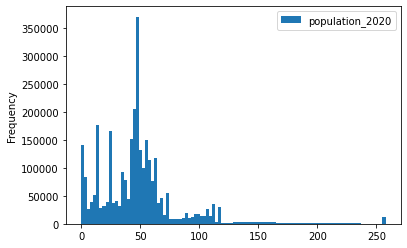

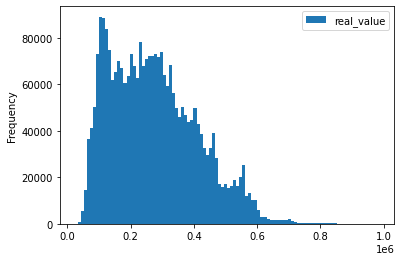

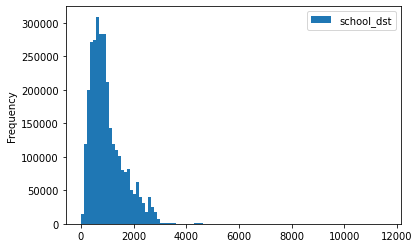

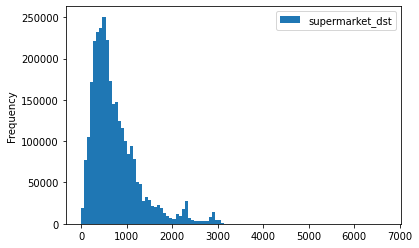

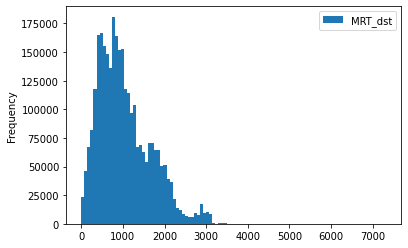

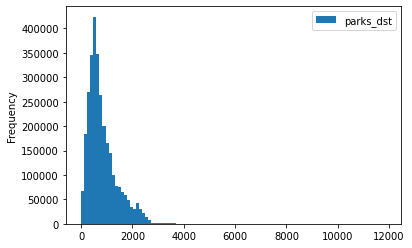

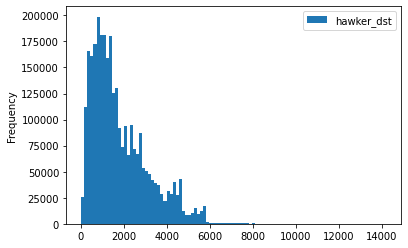

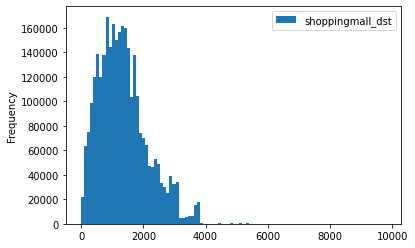

In [4]:
df[['population_2020']].plot.hist(bins=100)
df[['real_value']].plot.hist(bins=100)
df[['school_dst']].plot.hist(bins=100)
df[['supermarket_dst']].plot.hist(bins=100)
df[['MRT_dst']].plot.hist(bins=100)
df[['parks_dst']].plot.hist(bins=100)
df[['hawker_dst']].plot.hist(bins=100)
df[['shoppingmall_dst']].plot.hist(bins=100)

In [5]:
df['population_2020'].median(), df['real_value'].median(), \
    df['school_dst'].median(), df['supermarket_dst'].median(), \
    df['MRT_dst'].median(), df['parks_dst'].median(), \
    df['hawker_dst'].median(), df['shoppingmall_dst'].median()

(47.4801539139226,
 259181.1521086194,
 839.5806191969211,
 597.4577547000092,
 908.8867915808553,
 670.049006957932,
 1415.8417192942873,
 1247.9081733780883)

### Calculate features

In [6]:
trip_info = df.groupby('trj_id').agg(
    {'trj_id': 'first', 'driving_mode': 'first', 'osname': 'first'})

In [7]:
grouped = df.groupby("trj_id")
trip_info['start_time'] = grouped['pingtimestamp'].aggregate(min)
trip_info['end_time'] = grouped['pingtimestamp'].aggregate(max)
trip_info['eta'] = trip_info['end_time'] - trip_info['start_time']
trip_info['eta'] = trip_info['eta'].dt.seconds.div(60).astype(int) + trip_info['eta'].dt.days.multiply(1440).astype(int)
trip_info['start_lat'] = grouped['rawlat'].aggregate('first')
trip_info['end_lat'] = grouped['rawlat'].aggregate('last')
trip_info['start_lng'] = grouped['rawlng'].aggregate('first')
trip_info['end_lng'] = grouped['rawlng'].aggregate('last')
trip_info['time_of_day'] = trip_info['start_time'].dt.hour
trip_info['day_of_week'] = trip_info['start_time'].dt.weekday
trip_info['avg_speed'] = grouped['speed'].aggregate('mean')
trip_info['median_speed'] = grouped['speed'].aggregate('median')

trip_info

,trj_id,driving_mode,osname,start_time,end_time,eta,start_lat,end_lat,start_lng,end_lng,time_of_day,day_of_week,avg_speed,median_speed
trj_id,,,,,,,,,,,,,,
10,10,car,android,2019-04-09 11:25:54,2019-04-09 11:44:54,19,1.301581,1.358010,103.799431,103.845159,11,1,10.115351,9.810790
100,100,car,ios,2019-04-16 02:44:24,2019-04-16 03:00:37,16,1.344114,1.335289,103.938375,103.843102,2,1,16.050153,15.548959
1000,1000,car,ios,2019-04-11 00:49:45,2019-04-11 01:03:22,13,1.434515,1.370538,103.788474,103.860748,0,3,16.961335,18.197599
10001,10001,car,android,2019-04-17 11:56:50,2019-04-17 12:17:05,20,1.375087,1.328267,103.833377,103.750637,11,2,14.678651,16.189302
10004,10004,car,ios,2019-04-09 03:12:39,2019-04-09 03:26:37,13,1.433348,1.393925,103.768741,103.907360,3,1,22.175203,23.333824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,997,car,ios,2019-04-12 07:36:26,2019-04-12 07:56:08,19,1.318928,1.368076,103.847829,103.945997,7,4,15.336894,15.386393
9970,9970,car,android,2019-04-18 09:25:42,2019-04-18 09:54:53,29,1.434793,1.316889,103.788481,103.873316,9,3,12.458966,13.613062
998,998,car,ios,2019-04-18 22:30:33,2019-04-18 22:51:01,20,1.334752,1.296571,103.698884,103.852597,22,3,19.959847,21.698956


### Calculate distance of path

In [8]:
import geopy.distance
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=16)

num_in_group = grouped.cumcount()
df['rawlat_lag'] = grouped['rawlat'].shift()
df['rawlng_lag'] = grouped['rawlng'].shift()
df_dist = df.loc[num_in_group>0, ['trj_id', 'rawlat', 'rawlng', 'rawlat_lag', 'rawlng_lag']]
# print(df.isna().sum(), df_dist.isna().sum(), df_dist.shape, df.shape)

df_dist['dist'] = df_dist.parallel_apply(lambda x: geopy.distance.geodesic(
    (x[3], x[4]), (x[1], x[2])), axis=1)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [9]:
trip_info['distance'] = df_dist.groupby('trj_id').aggregate({'dist': 'sum'})
df = df.drop(columns=['rawlat_lag', 'rawlng_lag'], errors='ignore')
print(df.shape, trip_info.shape)
trip_info

(3034553, 35) (28000, 15)


,trj_id,driving_mode,osname,start_time,end_time,eta,start_lat,end_lat,start_lng,end_lng,time_of_day,day_of_week,avg_speed,median_speed,distance
trj_id,,,,,,,,,,,,,,,
10,10,car,android,2019-04-09 11:25:54,2019-04-09 11:44:54,19,1.301581,1.358010,103.799431,103.845159,11,1,10.115351,9.810790,9.875596106831226 km
100,100,car,ios,2019-04-16 02:44:24,2019-04-16 03:00:37,16,1.344114,1.335289,103.938375,103.843102,2,1,16.050153,15.548959,12.813825447690116 km
1000,1000,car,ios,2019-04-11 00:49:45,2019-04-11 01:03:22,13,1.434515,1.370538,103.788474,103.860748,0,3,16.961335,18.197599,13.478590676337191 km
10001,10001,car,android,2019-04-17 11:56:50,2019-04-17 12:17:05,20,1.375087,1.328267,103.833377,103.750637,11,2,14.678651,16.189302,16.901128236843014 km
10004,10004,car,ios,2019-04-09 03:12:39,2019-04-09 03:26:37,13,1.433348,1.393925,103.768741,103.907360,3,1,22.175203,23.333824,18.371994980644217 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,997,car,ios,2019-04-12 07:36:26,2019-04-12 07:56:08,19,1.318928,1.368076,103.847829,103.945997,7,4,15.336894,15.386393,16.93948363952553 km
9970,9970,car,android,2019-04-18 09:25:42,2019-04-18 09:54:53,29,1.434793,1.316889,103.788481,103.873316,9,3,12.458966,13.613062,20.108965345697012 km
998,998,car,ios,2019-04-18 22:30:33,2019-04-18 22:51:01,20,1.334752,1.296571,103.698884,103.852597,22,3,19.959847,21.698956,21.94372621143787 km


## Calculate other time costs

In [10]:
# trip_info = pd.read_csv('trip_info0.csv')
print(trip_info.shape)
trip_info

(28000, 15)


,trj_id,driving_mode,osname,start_time,end_time,eta,start_lat,end_lat,start_lng,end_lng,time_of_day,day_of_week,avg_speed,median_speed,distance
trj_id,,,,,,,,,,,,,,,
10,10,car,android,2019-04-09 11:25:54,2019-04-09 11:44:54,19,1.301581,1.358010,103.799431,103.845159,11,1,10.115351,9.810790,9.875596106831226 km
100,100,car,ios,2019-04-16 02:44:24,2019-04-16 03:00:37,16,1.344114,1.335289,103.938375,103.843102,2,1,16.050153,15.548959,12.813825447690116 km
1000,1000,car,ios,2019-04-11 00:49:45,2019-04-11 01:03:22,13,1.434515,1.370538,103.788474,103.860748,0,3,16.961335,18.197599,13.478590676337191 km
10001,10001,car,android,2019-04-17 11:56:50,2019-04-17 12:17:05,20,1.375087,1.328267,103.833377,103.750637,11,2,14.678651,16.189302,16.901128236843014 km
10004,10004,car,ios,2019-04-09 03:12:39,2019-04-09 03:26:37,13,1.433348,1.393925,103.768741,103.907360,3,1,22.175203,23.333824,18.371994980644217 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,997,car,ios,2019-04-12 07:36:26,2019-04-12 07:56:08,19,1.318928,1.368076,103.847829,103.945997,7,4,15.336894,15.386393,16.93948363952553 km
9970,9970,car,android,2019-04-18 09:25:42,2019-04-18 09:54:53,29,1.434793,1.316889,103.788481,103.873316,9,3,12.458966,13.613062,20.108965345697012 km
998,998,car,ios,2019-04-18 22:30:33,2019-04-18 22:51:01,20,1.334752,1.296571,103.698884,103.852597,22,3,19.959847,21.698956,21.94372621143787 km


In [11]:
grouped = df.groupby("trj_id")
trip_info['crowded_cost_raw'] = grouped['population_2020'].aggregate('sum') # has 162 na
trip_info['col_cost_raw'] = grouped['real_value'].aggregate('sum') # has 240725 na
trip_info['school_cost_raw'] = grouped['school_dst'].aggregate('sum')
trip_info['supermarket_cost_raw'] = grouped['supermarket_dst'].aggregate('sum')
trip_info['mrt_cost_raw'] = grouped['MRT_dst'].aggregate('sum')
trip_info['parks_cost_raw'] = grouped['parks_dst'].aggregate('sum')
trip_info['hawker_cost_raw'] = grouped['hawker_dst'].aggregate('sum')
trip_info['mall_cost_raw'] = grouped['shoppingmall_dst'].aggregate('sum')

trip_info

,trj_id,driving_mode,osname,start_time,end_time,eta,start_lat,end_lat,start_lng,end_lng,...,median_speed,distance,crowded_cost_raw,col_cost_raw,school_cost_raw,supermarket_cost_raw,mrt_cost_raw,parks_cost_raw,hawker_cost_raw,mall_cost_raw
trj_id,,,,,,,,,,,,,,,,,,,,,
10,10,car,android,2019-04-09 11:25:54,2019-04-09 11:44:54,19,1.301581,1.358010,103.799431,103.845159,...,9.810790,9.875596106831226 km,3430.071615,2.414459e+07,80318.323406,71209.204326,65360.680833,61291.150275,82514.193487,184651.031815
100,100,car,ios,2019-04-16 02:44:24,2019-04-16 03:00:37,16,1.344114,1.335289,103.938375,103.843102,...,15.548959,12.813825447690116 km,3913.831217,1.861623e+07,40334.641378,34867.143547,37473.785773,51971.094876,55751.529708,86133.525459
1000,1000,car,ios,2019-04-11 00:49:45,2019-04-11 01:03:22,13,1.434515,1.370538,103.788474,103.860748,...,18.197599,13.478590676337191 km,4971.263997,2.036504e+07,144485.305612,146777.121362,153214.510998,90546.674437,236420.296640,202199.242965
10001,10001,car,android,2019-04-17 11:56:50,2019-04-17 12:17:05,20,1.375087,1.328267,103.833377,103.750637,...,16.189302,16.901128236843014 km,4176.082715,4.609325e+07,113762.916444,96988.126013,154503.296103,60117.867762,150613.936923,171321.752046
10004,10004,car,ios,2019-04-09 03:12:39,2019-04-09 03:26:37,13,1.433348,1.393925,103.768741,103.907360,...,23.333824,18.371994980644217 km,7424.288503,2.276629e+07,115756.804538,111243.706165,116084.729789,71307.442009,272666.613184,164995.758018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,997,car,ios,2019-04-12 07:36:26,2019-04-12 07:56:08,19,1.318928,1.368076,103.847829,103.945997,...,15.386393,16.93948363952553 km,3814.873822,2.499747e+07,68615.993833,48700.778328,73232.484405,77204.662607,154945.062613,120198.455871
9970,9970,car,android,2019-04-18 09:25:42,2019-04-18 09:54:53,29,1.434793,1.316889,103.788481,103.873316,...,13.613062,20.108965345697012 km,9816.876493,3.799137e+07,197973.702719,182317.357572,188445.635787,160470.753595,352253.121336,324259.595355
998,998,car,ios,2019-04-18 22:30:33,2019-04-18 22:51:01,20,1.334752,1.296571,103.698884,103.852597,...,21.698956,21.94372621143787 km,3427.371978,1.697243e+07,122975.043366,61208.367626,105352.456211,87581.294808,131134.787479,105556.109419


In [12]:
df['is_crowded'] = df['population_2020'] > df['population_2020'].median()
df['is_real_value'] = df['real_value'] > df['real_value'].median()
df['is_near_school'] = df['school_dst'] < df['school_dst'].median()
df['is_near_supermarket'] = df['supermarket_dst'] < df['supermarket_dst'].median()
df['is_near_mrt'] = df['MRT_dst'] < df['MRT_dst'].median()
df['is_near_park'] = df['parks_dst'] < df['parks_dst'].median()
df['is_near_hawker'] = df['hawker_dst'] < df['hawker_dst'].median()
df['is_near_mall'] = df['shoppingmall_dst'] < df['shoppingmall_dst'].median()

df['crowded_cost'] = df['is_crowded'] * df['population_2020']
df['col_cost'] = df['is_real_value'] * df['real_value']
df['school_cost'] = df['is_near_school'] * df['school_dst']
df['supermarket_cost'] = df['is_near_supermarket'] * df['supermarket_dst']
df['mrt_cost'] = df['is_near_mrt'] * df['MRT_dst']
df['park_cost'] = df['is_near_park'] * df['parks_dst']
df['hawker_cost'] = df['is_near_mall'] * df['hawker_dst']
df['mall_cost'] = df['is_near_hawker'] * df['shoppingmall_dst']

print(df.shape)
df

(3034553, 51)


,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,population_2020,...,is_near_hawker,is_near_mall,crowded_cost,col_cost,school_cost,supermarket_cost,mrt_cost,park_cost,hawker_cost,mall_cost
2371260,70895,car,android,2019-04-08 00:09:40,1.380403,103.770900,6.799661,41,4.000,107.026190,...,False,True,107.026190,418413.076218,203.413152,278.147919,200.974500,0.000000,4570.221102,0.000000
2368174,70895,car,android,2019-04-08 00:09:41,1.380432,103.770924,4.931891,39,4.000,107.026190,...,False,True,107.026190,416064.044917,207.038228,277.715140,199.095975,0.000000,4573.158586,0.000000
2375481,70895,car,android,2019-04-08 00:09:42,1.380443,103.770933,3.228720,39,3.653,107.026190,...,False,True,107.026190,414879.087529,208.340464,277.554769,198.427328,0.000000,4574.184055,0.000000
2276162,21926,car,android,2019-04-08 00:09:49,1.291294,103.862687,10.812810,68,4.000,3.632434,...,True,True,0.000000,0.000000,0.000000,561.102689,270.883383,235.516318,1294.035859,320.764744
1456786,47498,car,ios,2019-04-08 00:09:52,1.375407,103.736028,18.307493,307,8.000,54.452414,...,False,True,54.452414,309918.610500,556.329536,436.811264,0.000000,0.000000,3466.596186,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426340,81574,car,ios,2019-04-21 23:56:31,1.338742,103.976407,17.994995,114,8.000,24.865106,...,False,False,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
842499,54687,car,android,2019-04-21 23:56:32,1.439879,103.787086,7.880000,298,4.551,116.212307,...,True,True,116.212307,626942.943318,277.335675,538.685466,340.092707,0.000000,1182.198087,437.846007
424309,81574,car,ios,2019-04-21 23:56:33,1.338589,103.976696,17.374184,117,8.000,21.450959,...,False,False,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
831815,54687,car,android,2019-04-21 23:56:35,1.439955,103.786952,4.130000,299,4.551,116.212307,...,True,True,116.212307,660630.174789,277.974503,545.438229,345.991847,0.000000,1165.216909,442.296368


In [13]:
features = df.groupby('trj_id').agg(
    {'is_crowded': 'mean', 
     'is_real_value': 'mean', 
     'is_near_school': 'mean',
     'is_near_supermarket': 'mean',
     'is_near_mrt': 'mean',
     'is_near_park': 'mean',
     'is_near_hawker': 'mean',
     'is_near_mall': 'mean',
     'crowded_cost': 'sum',
     'col_cost': 'sum',
     'school_cost': 'sum',
     'supermarket_cost': 'sum',
     'mrt_cost': 'sum',
     'park_cost': 'sum',
     'hawker_cost': 'sum',
     'mall_cost': 'sum',
    })

features

,is_crowded,is_real_value,is_near_school,is_near_supermarket,is_near_mrt,is_near_park,is_near_hawker,is_near_mall,crowded_cost,col_cost,school_cost,supermarket_cost,mrt_cost,park_cost,hawker_cost,mall_cost
trj_id,,,,,,,,,,,,,,,,
10,0.307692,0.375000,0.682692,0.596154,0.740385,0.701923,0.884615,0.278846,1679.009027,1.621966e+07,37711.307121,23443.312166,33049.903242,28540.032386,20804.972121,163074.872969
100,0.722222,0.458333,0.902778,0.722222,0.944444,0.347222,0.958333,0.527778,3004.769751,1.285090e+07,33897.845423,20239.015745,33089.814690,9224.462377,22165.576541,79981.218805
1000,0.651685,0.348315,0.157303,0.146067,0.213483,0.382022,0.056180,0.101124,4157.077695,9.695456e+06,5654.307026,4317.018190,10138.590469,16975.938439,17376.796914,6711.678793
10001,0.314050,0.776860,0.438017,0.355372,0.256198,0.735537,0.619835,0.421488,2069.156527,4.076255e+07,30824.298730,15721.114146,19191.117316,29483.275556,50262.351555,91670.498518
10004,0.809524,0.500000,0.309524,0.404762,0.428571,0.452381,0.000000,0.369048,7041.028470,1.480271e+07,15158.036542,16369.429706,19470.317008,18878.028041,105991.711652,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,0.402439,0.548780,0.560976,0.658537,0.731707,0.304878,0.512195,0.256098,2060.417732,1.941092e+07,27763.646673,21858.937237,37093.933146,13207.146447,36227.189779,60865.983247
9970,0.707602,0.368421,0.514620,0.380117,0.578947,0.532164,0.228070,0.163743,8350.775257,1.967036e+07,53180.493502,24346.111444,49185.880548,44976.279678,43611.714870,55270.423751
998,0.324324,0.207207,0.306306,0.684685,0.486486,0.504505,0.639640,0.765766,2242.908473,7.702894e+06,19313.573476,24819.024550,25072.155762,22435.687414,79589.388811,49974.176931


In [14]:
trip_info = pd.concat((trip_info, features), axis=1)
trip_info.to_csv('trip_info0.csv')